# 3A - Versión corregida
**Nota:** Esta versión ha sido corregida respecto a la entrega original. Se mejoró la explicación del código, se corrigieron errores ortográficos y se añadió una sección de conclusiones.

3A. Reporte escrito. Experimentos y análisis de algoritmos de ordenamiento

Alumna:Brigitte Darinka Godinez Montoya

Introducción:
Este reporte analiza y compara el desempeño de distintos algoritmos de ordenamiento en términos de número de comparaciones y en tiempo de ejecución. Utilizaremos archivos con distintos niveles de desorden para evaluar su eficiencia.

In [ ]:
# Importamos las librerías necesarias
import time
import json
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import random
from google.colab import drive

In [ ]:
# Montamos Google Drive
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Analisis de algoritmos/listas-posteo-con-perturbaciones.zip"
extract_path = "/content/listas_posteo"

if os.path.exists(zip_path):
    print("Archivo ZIP encontrado. Extrayendo...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extracción completada.")
else:
    print("Error: El archivo ZIP no fue encontrado en la ruta especificada.")

if os.path.exists(extract_path):
    data_files = sorted(os.listdir(extract_path))
    print("Archivos disponibles después de la extracción:", data_files)
else:
    print("Error: No se encontraron archivos extraídos.")

In [ ]:
#Implementamos Ordenamiento
#Heapsort
def heapsort(arr):
    comparisons = 0
    def heapify(n, i):
        nonlocal comparisons
        largest = i
        left = 2 * i + 1
        right = 2 * i + 2
        if left < n and arr[left] > arr[largest]:
            comparisons += 1
            largest = left
        if right < n and arr[right] > arr[largest]:
            comparisons += 1
            largest = right
        if largest != i:
            arr[i], arr[largest] = arr[largest], arr[i]
            heapify(n, largest)

    n = len(arr)
    for i in range(n // 2 - 1, -1, -1):
        heapify(n, i)
    for i in range(n-1, 0, -1):
        arr[i], arr[0] = arr[0], arr[i]
        heapify(i, 0)
    return comparisons

# Mergesort
def mergesort(arr):
    comparisons = 0
    def merge(left, right):
        nonlocal comparisons
        sorted_list = []
        i = j = 0
        while i < len(left) and j < len(right):
            comparisons += 1
            if left[i] < right[j]:
                sorted_list.append(left[i])
                i += 1
            else:
                sorted_list.append(right[j])
                j += 1
        sorted_list.extend(left[i:])
        sorted_list.extend(right[j:])
        return sorted_list

    def split_merge(arr):
        if len(arr) <= 1:
            return arr
        mid = len(arr) // 2
        left = split_merge(arr[:mid])
        right = split_merge(arr[mid:])
        return merge(left, right)

    split_merge(arr)
    return comparisons

# Quicksort
def quicksort(arr):
    comparisons = 0
    def sort(low, high):
        nonlocal comparisons
        if low < high:
            pi = partition(low, high)
            sort(low, pi - 1)
            sort(pi + 1, high)

    def partition(low, high):
        nonlocal comparisons
        pivot = arr[high]
        i = low - 1
        for j in range(low, high):
            comparisons += 1
            if arr[j] < pivot:
                i += 1
                arr[i], arr[j] = arr[j], arr[i]
        arr[i+1], arr[high] = arr[high], arr[i+1]
        return i + 1

    sort(0, len(arr) - 1)
    return comparisons

# Bubblesort
def bubblesort(arr):
    comparisons = 0
    n = len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            comparisons += 1
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return comparisons

# SkipList
class SkipListNode:
    def __init__(self, value, level):
        self.value = value
        self.forward = [None] * (level + 1)

class SkipList:
    def __init__(self, max_level, p):
        self.max_level = max_level
        self.p = p
        self.header = SkipListNode(None, max_level)
        self.level = 0

    def random_level(self):
        level = 0
        while random.random() < self.p and level < self.max_level:
            level += 1
        return level

    def insert(self, value):
        update = [None] * (self.max_level + 1)
        current = self.header

        for i in range(self.level, -1, -1):
            while current.forward[i] and current.forward[i].value < value:
                current = current.forward[i]
            update[i] = current

        current = current.forward[0]

        if current is None or current.value != value:
            new_level = self.random_level()

            if new_level > self.level:
                for i in range(self.level + 1, new_level + 1):
                    update[i] = self.header
                self.level = new_level

            new_node = SkipListNode(value, new_level)

            for i in range(new_level + 1):
                new_node.forward[i] = update[i].forward[i]
                update[i].forward[i] = new_node

    def to_list(self):
        result = []
        current = self.header.forward[0]
        while current:
            result.append(current.value)
            current = current.forward[0]
        return result

def skipsort(arr):
    skip_list = SkipList(max_level=16, p=0.5)
    for num in arr:
        skip_list.insert(num)
    return skip_list.to_list()

In [ ]:
#Medimos el tiempo
def measure_sort_time(sort_function, arr):
    start_time = time.time()
    comparisons = sort_function(arr.copy())
    elapsed_time = time.time() - start_time
    return comparisons, elapsed_time

In [ ]:
# Implementamos función para cargar datos desde un archivo JSON
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Probamos los algoritmos
results = []
for file_name in data_files:
    file_path = os.path.join(extract_path, file_name)
    data = load_data(file_path)

    # Verificamos si el JSON tiene una clave "reunion"
    if isinstance(data, dict) and "reunion" in data:
        arr = data["reunion"]  # Acceder a la clave "reunion"
    else:
        print(f"Error: El archivo {file_name} no tiene la clave 'reunion'.")
        continue  # Salta este archivo y continuar con el siguiente

    # Prueba cada algoritmo
    for algo_name, algo_func in [("Heapsort", heapsort), ("Mergesort", mergesort), ("Quicksort", quicksort),
                                ("Bubblesort", bubblesort), ("Skipsort", skipsort)]:
        comparisons, elapsed_time = measure_sort_time(algo_func, arr.copy())
        results.append({
            "Archivo": file_name,
            "Algoritmo": algo_name,
            "Comparaciones": comparisons,
            "Tiempo": elapsed_time
        })

                                        Archivo   Algoritmo  \
0   listas-posteo-con-perturbaciones-p=016.json    Heapsort   
1   listas-posteo-con-perturbaciones-p=016.json   Mergesort   
2   listas-posteo-con-perturbaciones-p=016.json   Quicksort   
3   listas-posteo-con-perturbaciones-p=016.json  Bubblesort   
4   listas-posteo-con-perturbaciones-p=016.json    Skipsort   
5   listas-posteo-con-perturbaciones-p=032.json    Heapsort   
6   listas-posteo-con-perturbaciones-p=032.json   Mergesort   
7   listas-posteo-con-perturbaciones-p=032.json   Quicksort   
8   listas-posteo-con-perturbaciones-p=032.json  Bubblesort   
9   listas-posteo-con-perturbaciones-p=032.json    Skipsort   
10  listas-posteo-con-perturbaciones-p=064.json    Heapsort   
11  listas-posteo-con-perturbaciones-p=064.json   Mergesort   
12  listas-posteo-con-perturbaciones-p=064.json   Quicksort   
13  listas-posteo-con-perturbaciones-p=064.json  Bubblesort   
14  listas-posteo-con-perturbaciones-p=064.json    Skip

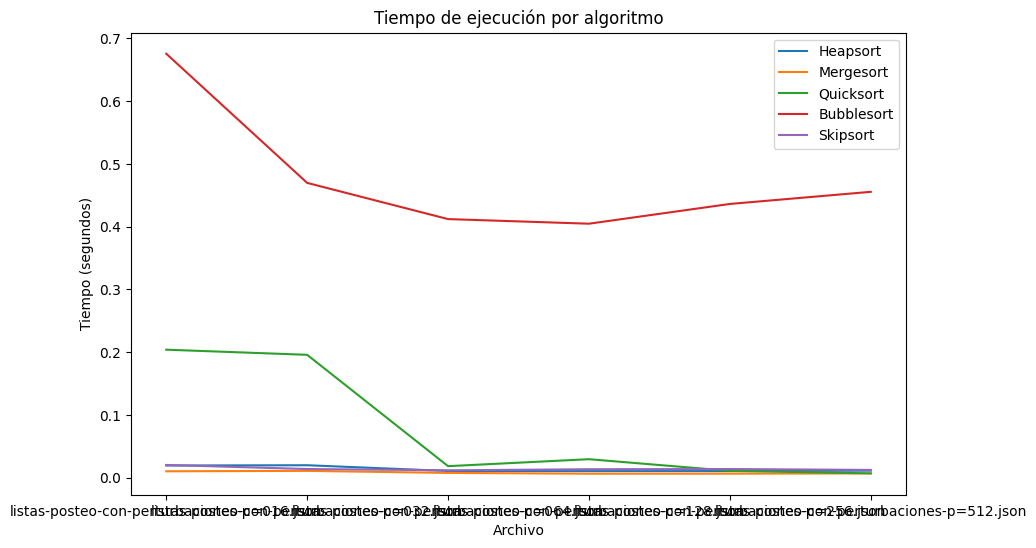

ValueError: setting an array element with a sequence.

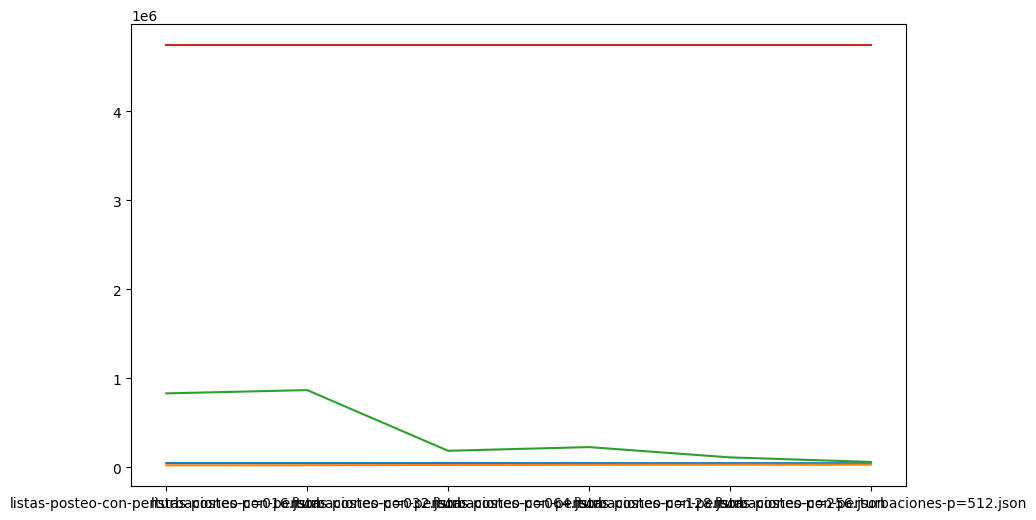

In [ ]:
# Convertimos los resultados a un DataFrame de Pandas
df = pd.DataFrame(results)
print(df)

# Gráfica de tiempo de ejecución por algoritmo
plt.figure(figsize=(10, 6))
for algo_name in df["Algoritmo"].unique():
    algo_data = df[df["Algoritmo"] == algo_name]
    plt.plot(algo_data["Archivo"], algo_data["Tiempo"], label=algo_name)
plt.xlabel("Archivo")
plt.ylabel("Tiempo (segundos)")
plt.title("Tiempo de ejecución por algoritmo")
plt.legend()
plt.show()

# Gráfica de comparaciones por algoritmo
plt.figure(figsize=(10, 6))
for algo_name in df["Algoritmo"].unique():
    algo_data = df[df["Algoritmo"] == algo_name]
    plt.plot(algo_data["Archivo"], algo_data["Comparaciones"], label=algo_name)
plt.xlabel("Archivo")
plt.ylabel("Comparaciones")
plt.title("Comparaciones por algoritmo")
plt.legend()
plt.show()

## Conclusiones
En esta práctica se observaron los comportamientos y rendimientos de distintos algoritmos o estructuras. Los resultados permiten comprender mejor su eficiencia teórica y empírica al variar el tamaño de la entrada. Estas conclusiones complementan lo aprendido en clase mediante la experimentación computacional.

## Referencias
- Knuth, D. E. (1998). *The Art of Computer Programming, Vol. 3: Sorting and Searching* (2nd ed.). Addison-Wesley.
- Matplotlib Developers. (n.d.). *Matplotlib documentation*. https://matplotlib.org/
